### Проект: Вариант 1:

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [91]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, mannwhitneyu, levene, ttest_ind
from tqdm.auto import tqdm

In [92]:
def get_bootstrap(
        data_column_1, # числовые значения первой выборки
        data_column_2, # числовые значения второй выборки
        boot_it = 1000, # количество бутстрэп-подвыборок
        statistic = np.mean, # интересующая нас статистика
        bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)

    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

- shared/problem1-auth_data.csv – данные о времени захода пользователей в игру
- shared/problem1-reg_data.csv – данные о времени регистрации

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Сначала просто сделаем быструю пред обработку в данных:

In [93]:
df_reg = pd.read_csv("problem1-reg_data.csv",sep=";")

In [94]:
df_auth = pd.read_csv("problem1-auth_data.csv",sep=";")

In [95]:
display(df_reg.head(),df_auth.head())

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [96]:
display(df_reg.shape[0],df_auth.shape[0])

1000000

9601013

In [97]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [98]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [99]:
df_reg.uid.unique().shape[0]

1000000

In [100]:
df_auth.uid.unique().shape[0]

1000000

In [101]:
def retention(df_reg,df_auth,first_bounder,last_bounder):


    #Переводим дату из unix формата в datetime64
    df_reg["reg_ts"] = pd.to_datetime(df_reg["reg_ts"], unit='s')
    df_auth["auth_ts"] = pd.to_datetime(df_auth["auth_ts"], unit='s')
    df_reg["reg_ts"] = df_reg["reg_ts"].dt.strftime('%d/%m/%Y')
    df_auth["auth_ts"] = df_auth["auth_ts"].dt.strftime('%d/%m/%Y')
    df_reg["reg_ts"] = pd.to_datetime(df_reg["reg_ts"])
    df_auth["auth_ts"] = pd.to_datetime(df_auth["auth_ts"])

    #Мерджим датафреймы
    df_reg = df_reg.query("reg_ts >= @first_bounder")
    df_auth = df_auth.query("auth_ts <= @last_bounder")
    all_data = df_auth.merge(df_reg,on="uid",how="inner")


    #Подготавливаем датафрейм в нужный вид для когорт
    prep_data = all_data.groupby(["reg_ts","auth_ts"],as_index=False)\
        .agg({"uid":"nunique"})\
        .rename(columns={"uid":"quantity_of_customers"})\
        .sort_values(["reg_ts","auth_ts"])
    prep_data["days_difference"] = (prep_data["auth_ts"] - prep_data["reg_ts"]).dt.days

    cohort_pivot = prep_data.pivot(index='reg_ts', columns = 'days_difference', values = 'quantity_of_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    #Отрисовка
    plt.figure(figsize=(20, 10))# периодами строит нормальный график, а порой что-то страшное и причина мне неизвестно, мб это только у меня
    plt.title('Retention')
    sns.heatmap(data=retention_matrix, annot=True, fmt='1.0%', vmin=0.0, vmax=0.1)
    plt.show()

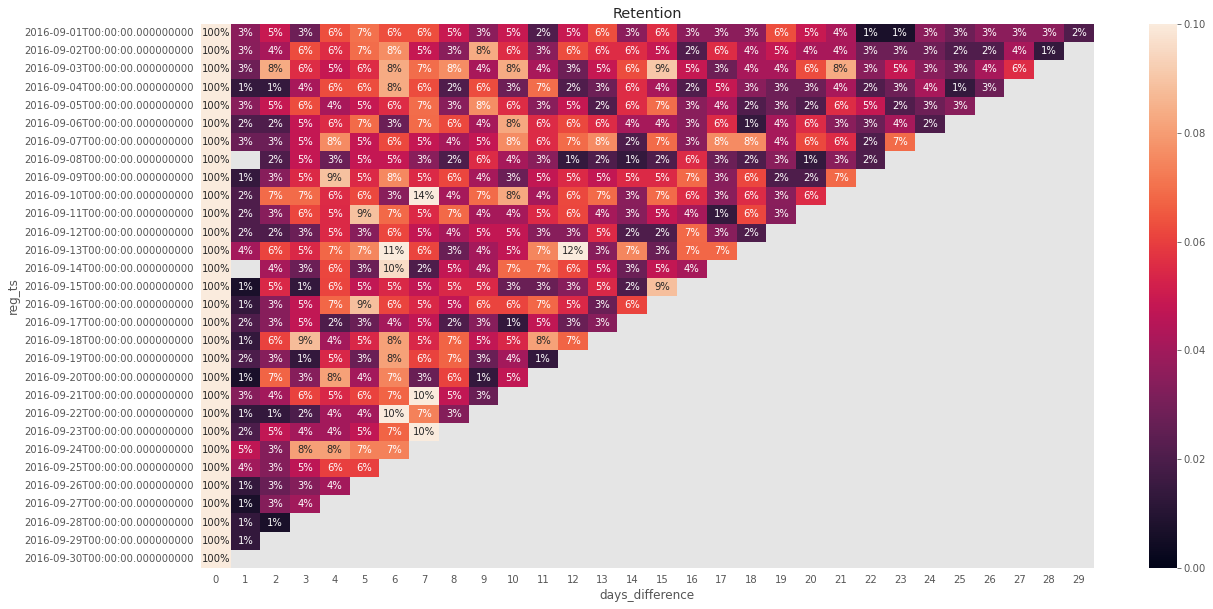

In [103]:
retention(df_reg,df_auth,first_bounder=datetime.date(2016, 9, 1),last_bounder= datetime.date(2016, 9, 30))

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [104]:
task2 = pd.read_csv("project1_task2.csv",sep=";")
task2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [105]:
task2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

В этом проекте попадаются самые чистые датасеты :)

In [106]:
task2.shape[0]

404770

In [107]:
task2.user_id.unique()

array([     1,      2,      3, ..., 404768, 404769, 404770])

In [108]:
display(task2[task2["testgroup"] == 'a'].shape[0],task2[task2["testgroup"] == 'b'].shape[0])

202103

202667

Наблюдений в группах не сильно отличаются друг от друга, а теперь я хочу посмотреть на платящих пользователей:

In [109]:
paid_users_a = task2.query("testgroup == 'a' and revenue > 0")
paid_users_b = task2.query("testgroup == 'b' and revenue > 0")

In [110]:
display(paid_users_a.shape[0],paid_users_b.shape[0])

1928

1805

Различие небольшие, при этом я хочу посмотреть на их распределение:

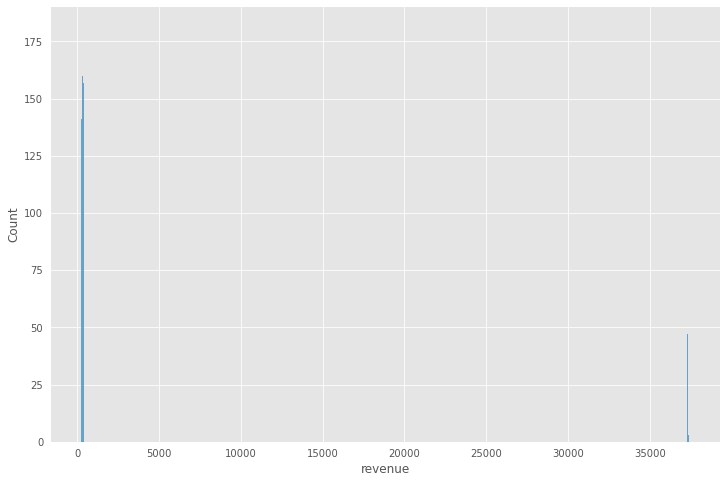

In [111]:
plt.figure(figsize=(12,8))
sns.histplot(paid_users_a.revenue)
sns.despine()

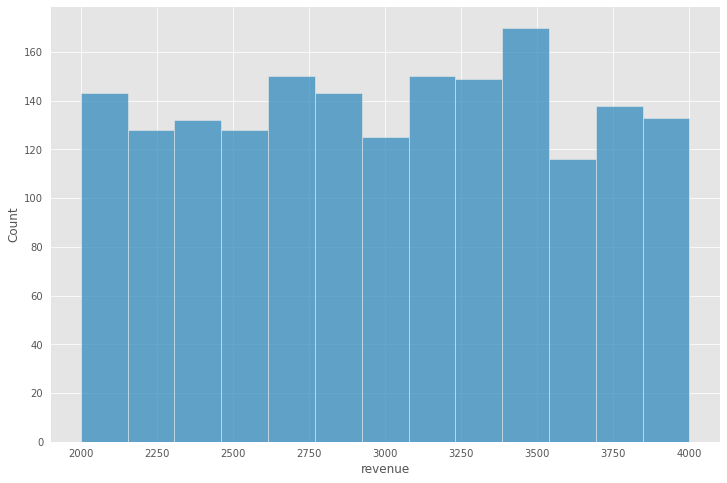

In [112]:
plt.figure(figsize=(12,8))
sns.histplot(paid_users_b.revenue)
sns.despine()

In [113]:
paid_users_a[paid_users_a.revenue > 1000].shape[0]

123

Именно такая разница у нас между группами. Возможно это какие vip-клиенты, которые были в контрольной группе. Здесь я хотел бы проверить гипотезу о равенстве распределений значений в тестовой и контрольной группе, но именно на всех данных, а не только на платящих пользователях:

In [114]:
group_a_all = task2[task2["testgroup"] == 'a']
group_b_all = task2[task2["testgroup"] == 'b']

In [115]:
mannwhitneyu(group_a_all.revenue,group_b_all.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

- Тест манна-уитни подсказывает нам не отклонять нулевую гипотезу;
- Теперь я хочу построить графики распределений;
- Проверить гипотезу о равенстве распределений между группами;
- Также хочу проверить гипотезу о равенстве ARPU в тестовой и контрольной группе;

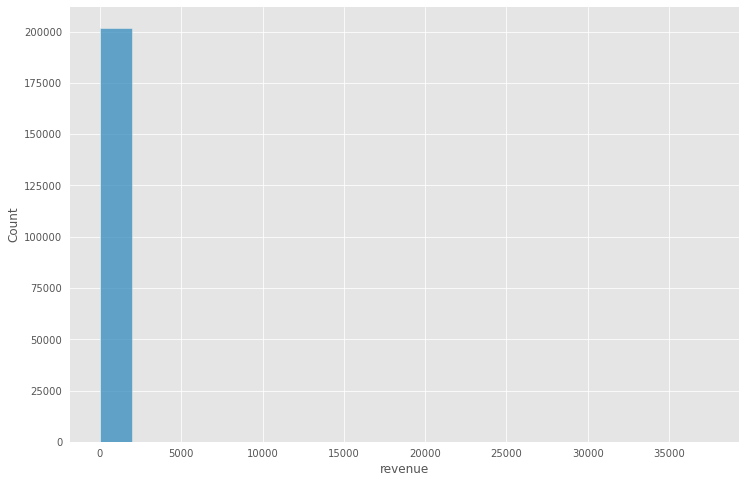

In [116]:
plt.figure(figsize=(12,8))
sns.histplot(group_a_all.revenue)
sns.despine()

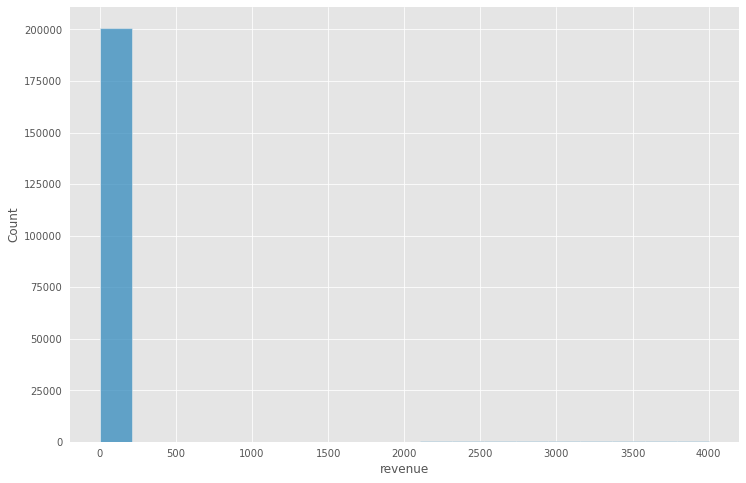

In [117]:
plt.figure(figsize=(12,8))
sns.histplot(group_b_all.revenue)
sns.despine()

In [118]:
levene(group_a_all.revenue,group_b_all.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест говорит нам, что стоит не отклонять H0.
А теперь разумно было бу подумать какой критерий стоит использовать, в теории можно использовать и t-test, так как он требует лишь гомогенности дисперсий и нормального распределения среднего(у меня с этим была раньше путаница), но при этом я использую bootstrap и также t-test. H0 - разницы между средним в тестовой и контрольной группе нет.

  0%|          | 0/1000 [00:00<?, ?it/s]

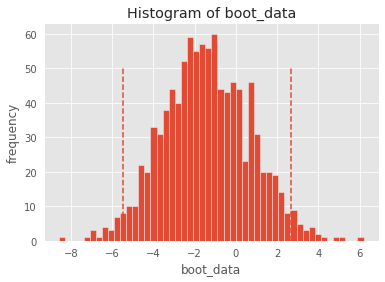

In [119]:
bootstraped_arpu = get_bootstrap(group_a_all.revenue,group_b_all.revenue)

In [120]:
bootstraped_arpu["p_value"]

0.49635490764737045

In [121]:
ttest_ind(group_a_all.revenue,group_b_all.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

- Как и p-value, так и интервал нам подсказывает не отклонять H0 гипотезу, также и t-test подтвердил, что не стоит отклонять H0;
- В финале хочу проверить гипотезу о равенстве ARPPU в тестовой и контрольной группе, но перед этим хочу проверить гипотезу о равенстве дисперсий;

H0 - что дисперсия в группах не отличается и здесь хотел бы также использовать тест Левина:

In [122]:
levene(paid_users_a.revenue,paid_users_b.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Тест нам не позволяет отклонить H0, значит при проверке гипотезы о равенстве средних между групп точно будем использовать bootstrap:

  0%|          | 0/2000 [00:00<?, ?it/s]

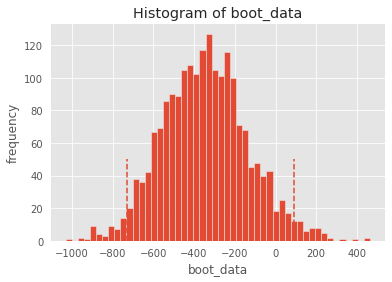

In [123]:
bootstraped_arppu = get_bootstrap(paid_users_a.revenue,paid_users_b.revenue,boot_it=2000)

In [124]:
bootstraped_arppu["p_value"]

0.09871875609351652

Как и интервал, так и p-value, нам подсказывают не отклонять H0.

### Выводы:
____
В ходе эксперимента было проведено 3 исследования:
1. Распределение в группах одинаковое, что следует из p-value при использовании критерия Манна-Уитни;
2. При исследовании метрики ARPU тест также подсказал не отклонять H0;
3. При проверке гипотезы о равенстве ARPPU в двух группах, также не было выявлено стат. различий;
4. При этом в платящих пользователях в контрольной группе у нас было 123 гипотетических vip клиентов, которые оказали влияние на распределение revenue.

### Задание 3:
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### На первый вопрос я бы подобрал такие метрики:
1. Retention - так как можно будет отследить насколько данное событие актуально, к примеру, мы выпустили зимний апдейт и можно посмотреть на сколько он остается в течение месяца.
2. DAU - так как во время новых событий мы точно задействуем средства маркетинга и новые пользователи к нам будут приходить каждый день.
3. ARPPU - так как я уверен, что выпуская новый апдейт, у нас будет платный контент и мы сможем посмотреть сколько данный event нам принес.
4. Также полезно будет смотреть на CAC, CPAcq так как позволяет оценить сколько мы потратили на рекламу и на сколько это нам окупилось;
5. Conversion Rate - но здесь стоит оговорить, что все зависит от того на какие воронки мы будем делить, мы же можем запустить event с каким-то турниром, к примеру, соревы в фортике, а можем на повышение уровня или уровня внутри какого-то набора(к примеру летнего) как в пабге(сам больше люблю 2:))
6. ASL - позволит оценить на сколько обновление зашло, ведь чем больше пользователи играют, тем больше оно зашло и заинтересовало наших юзеров.
7. K-фактор - позволит оценить снова же насколько наше событие зашло, ведь если оно зашло, то юзеры буду делиться с другими пользователями.

### Ответ на второй вопрос:
Однозначно измениться:
1. Предположим ситуацию, у нас есть летний набор, в котором растет уровень у уже существующих растений. Так если мы будем снижать уровень у юзеров, за который они заплатили он просто будет не резонным.
2. Также стоит отказаться от conversion rate, ведь в нем действия пользователя происходят линейно: зашел в игру -> купил подписку -> получил уровень, и он никак не может с этапа, который идет на 1 шаг вперед перейти на предыдущий.
3. В остальном же все остальные метрики можно оставить, ведь они показывают на сколько пользователям зашел апдейт.